In [3]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image

# For TResNet-M or EfficientNet
import timm

In [4]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
base_dir = '/content/drive/MyDrive/temple_classification'
output_dir = '/content/drive/MyDrive/temple_classification_output'

os.makedirs(output_dir, exist_ok=True)

# Define classes
church_styles = ['church_romanesque', 'church_modern', 'church_gothic', 'church_byzantine', 'church_baroque']
mosque_styles = ['mosque_turkish', 'mosque_persian', 'mosque_arabic']
all_classes = church_styles + mosque_styles

# Assuming you've already split your data into these directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

Using device: cpu


In [9]:
# 2. Custom transforms for data augmentation
class RandomResizedCrop(transforms.RandomResizedCrop):
    """Custom RandomResizedCrop to match the paper's specifications"""
    def __init__(self, size, scale=(0.4, 1.0), ratio=(3/4, 4/3)):
        super().__init__(size=size, scale=scale, ratio=ratio)

# OPTIMIZATION: Reduced image sizes from 224 to 160 for faster processing
train_transform = transforms.Compose([
    RandomResizedCrop(size=160, scale=(0.4, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(192),
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# High resolution transform reduced from 384 to 224
train_transform_high_res = transforms.Compose([
    RandomResizedCrop(size=224, scale=(0.4, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_high_res = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [11]:
from collections import Counter

print("Loading datasets...")
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=val_dir, transform=val_transform)
test_dataset = ImageFolder(root=test_dir, transform=val_transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Get class counts for balanced sampling
print("Calculating class counts...")
class_counts = [0] * len(all_classes)
for _, label in train_dataset.samples:
    class_counts[label] += 1
print(f"Class counts: {class_counts}")
print(f"Class names: {train_dataset.classes}")

# Calculate weights for balanced sampling
print("Calculating sample weights...")
class_weights = [1.0 / count if count > 0 else 0.0 for count in class_counts]
sample_weights = [class_weights[label] for _, label in train_dataset.samples]
print(f"Sample weights (first 10): {sample_weights[:10]}")

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
print("Sampler created.")

# Set batch size and create data loaders
batch_size = 64
print(f"Using batch size: {batch_size}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
balanced_train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders created successfully.")


Loading datasets...
Number of training samples: 3489
Number of validation samples: 955
Number of test samples: 1191
Calculating class counts...
Class counts: [696, 90, 788, 325, 620, 283, 283, 404]
Class names: ['church_baroque', 'church_byzantine', 'church_gothic', 'church_modern', 'church_romanesque', 'mosque_arabic', 'mosque_persian', 'mosque_turkish']
Calculating sample weights...
Sample weights (first 10): [0.0014367816091954023, 0.0014367816091954023, 0.0014367816091954023, 0.0014367816091954023, 0.0014367816091954023, 0.0014367816091954023, 0.0014367816091954023, 0.0014367816091954023, 0.0014367816091954023, 0.0014367816091954023]
Sampler created.
Using batch size: 64
DataLoaders created successfully.


In [12]:
def combine_datasets(train_dir, val_dir, output_dir, transform):
    print("Loading training and validation datasets...")
    train_dataset = ImageFolder(root=train_dir, transform=transform)
    val_dataset = ImageFolder(root=val_dir, transform=transform)
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    # Combine datasets
    print("Combining datasets...")
    combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
    print(f"Combined dataset size: {len(combined_dataset)}")

    # Calculate weights for balanced sampling
    print("Calculating class counts for combined dataset...")
    class_counts = [0] * len(all_classes)
    for dataset in [train_dataset, val_dataset]:
        for _, label in dataset.samples:
            class_counts[label] += 1
    print(f"Combined class counts: {class_counts}")

    print("Calculating class weights...")
    class_weights = [1.0 / count if count > 0 else 0.0 for count in class_counts]
    print(f"Class weights: {class_weights}")

    # Create sample weights
    print("Creating sample weights for combined dataset...")
    sample_weights = []
    for dataset in [train_dataset, val_dataset]:
        sample_weights.extend([class_weights[label] for _, label in dataset.samples])
    print(f"Sample weights (first 10): {sample_weights[:10]}")

    print("Creating samplers and dataloaders...")
    combined_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(combined_dataset), replacement=True)

    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    balanced_combined_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=combined_sampler, num_workers=2, pin_memory=True)

    print("Combined DataLoaders created.")

    return combined_dataset, combined_loader, balanced_combined_loader

In [14]:
# 5. Define the training function - OPTIMIZED with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=3, device=device):
    model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    no_improve_epochs = 0
    print("Starting training...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if i % 10 == 0:
                print(f"  [Batch {i}] Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f"  Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        scheduler.step()

        # Save best model and check for early stopping
        if val_epoch_acc > best_val_acc:
            print("  Improvement detected, saving model...")
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), os.path.join(output_dir, 'best_model.pth'))
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"  No improvement. ({no_improve_epochs}/{patience})")

        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

    return model, history


# Function to evaluate model
def evaluate_model(model, test_loader, criterion, device=device):
    print("\nEvaluating model on test set...")
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if i % 5 == 0:
                print(f"  Processed batch {i}")

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"\nTest Results — Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, Balanced Acc: {balanced_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return test_loss, test_acc, balanced_acc, cm_normalized, all_preds, all_labels


# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title, output_path):
    print(f"Saving confusion matrix plot to: {output_path}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print("Plot saved.")


In [15]:
# 6. Simplified hyperparameter tuning (OPTIMIZED with fixed parameters)
# OPTIMIZATION: Skip hyperparameter tuning and use known good values to save time
def get_best_params():
    return {'lr': 0.01, 'weight_decay': 1e-4}

# Get best parameters without lengthy tuning
best_params = get_best_params()
print(f"Using parameters: LR={best_params['lr']}, Weight Decay={best_params['weight_decay']}")

Using parameters: LR=0.01, Weight Decay=0.0001


In [16]:
# 7. Implement EfficientNet-B0 model (OPTIMIZATION: smaller and faster than ResNet-50)
def create_efficientnet_model(num_classes=len(all_classes)):
    # OPTIMIZATION: Use EfficientNet-B0 instead of ResNet-50
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
    return model

In [17]:
# 8. Create combined dataset for final training
combined_dataset, combined_loader, balanced_combined_loader = combine_datasets(
    train_dir,
    val_dir,
    output_dir,
    train_transform
)


Loading training and validation datasets...
Train dataset size: 3489
Validation dataset size: 955
Combining datasets...
Combined dataset size: 4444
Calculating class counts for combined dataset...
Combined class counts: [871, 113, 985, 407, 776, 373, 379, 540]
Calculating class weights...
Class weights: [0.001148105625717566, 0.008849557522123894, 0.0010152284263959391, 0.002457002457002457, 0.001288659793814433, 0.002680965147453083, 0.002638522427440633, 0.001851851851851852]
Creating sample weights for combined dataset...
Sample weights (first 10): [0.001148105625717566, 0.001148105625717566, 0.001148105625717566, 0.001148105625717566, 0.001148105625717566, 0.001148105625717566, 0.001148105625717566, 0.001148105625717566, 0.001148105625717566, 0.001148105625717566]
Creating samplers and dataloaders...
Combined DataLoaders created.


In [18]:
# 9. Train baseline model - OPTIMIZATION: using smaller and faster model
baseline_model = create_efficientnet_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(),
                     lr=best_params['lr'],
                     momentum=0.9,
                     weight_decay=best_params['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=15)

print("Training baseline model (EfficientNet-B0, 160x160, Imbalanced)")
baseline_model, baseline_history = train_model(
    baseline_model,
    combined_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=15,
    patience=3
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Training baseline model (EfficientNet-B0, 160x160, Imbalanced)
Starting training...

Epoch 1/15
  [Batch 0] Loss: 4.6313


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 2.6204


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 2.0576


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 30] Loss: 1.5990
  [Batch 40] Loss: 1.9828


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 50] Loss: 1.3781
  [Batch 60] Loss: 1.5736
  Train Loss: 2.1338, Train Acc: 0.4035
  Val Loss: 1.4368, Val Acc: 0.4962
  Improvement detected, saving model...

Epoch 2/15
  [Batch 0] Loss: 1.2169


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 10] Loss: 1.4475


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 20] Loss: 1.1552
  [Batch 30] Loss: 1.1243
  [Batch 40] Loss: 0.9527
  [Batch 50] Loss: 1.2162


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 60] Loss: 1.2372
  Train Loss: 1.1031, Train Acc: 0.5923
  Val Loss: 0.9415, Val Acc: 0.6667
  Improvement detected, saving model...

Epoch 3/15
  [Batch 0] Loss: 0.6502


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.8179


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 0.9549
  [Batch 30] Loss: 0.6723
  [Batch 40] Loss: 0.8440


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 50] Loss: 1.1521
  [Batch 60] Loss: 0.7323
  Train Loss: 0.8043, Train Acc: 0.7012
  Val Loss: 0.8412, Val Acc: 0.7128
  Improvement detected, saving model...

Epoch 4/15
  [Batch 0] Loss: 0.6197
  [Batch 10] Loss: 0.6071


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 0.6608
  [Batch 30] Loss: 0.5491


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 40] Loss: 0.5926
  [Batch 50] Loss: 0.7112


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 60] Loss: 0.8178
  Train Loss: 0.6307, Train Acc: 0.7703
  Val Loss: 0.7774, Val Acc: 0.7271
  Improvement detected, saving model...

Epoch 5/15
  [Batch 0] Loss: 0.4061
  [Batch 10] Loss: 0.5437
  [Batch 20] Loss: 0.5853


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 30] Loss: 0.4718
  [Batch 40] Loss: 0.4606
  [Batch 50] Loss: 0.5415
  [Batch 60] Loss: 0.5890


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  Train Loss: 0.5158, Train Acc: 0.8060
  Val Loss: 0.7145, Val Acc: 0.7624
  Improvement detected, saving model...

Epoch 6/15


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 0] Loss: 0.3695
  [Batch 10] Loss: 0.3727


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 0.2713
  [Batch 30] Loss: 0.3785
  [Batch 40] Loss: 0.3901
  [Batch 50] Loss: 0.3320
  [Batch 60] Loss: 0.3066
  Train Loss: 0.3996, Train Acc: 0.8522
  Val Loss: 0.7556, Val Acc: 0.7590
  No improvement. (1/3)

Epoch 7/15
  [Batch 0] Loss: 0.4145


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.4125
  [Batch 20] Loss: 0.2133
  [Batch 30] Loss: 0.2837


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 40] Loss: 0.3197
  [Batch 50] Loss: 0.2121


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 60] Loss: 0.2341
  Train Loss: 0.3197, Train Acc: 0.8864
  Val Loss: 0.7582, Val Acc: 0.7548
  No improvement. (2/3)

Epoch 8/15


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 0] Loss: 0.1378
  [Batch 10] Loss: 0.2365


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99562261 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 0.1961
  [Batch 30] Loss: 0.1822
  [Batch 40] Loss: 0.3676


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 50] Loss: 0.2994
  [Batch 60] Loss: 0.2095
  Train Loss: 0.2525, Train Acc: 0.9113
  Val Loss: 0.7803, Val Acc: 0.7792
  Improvement detected, saving model...

Epoch 9/15
  [Batch 0] Loss: 0.1531
  [Batch 10] Loss: 0.1837
  [Batch 20] Loss: 0.1519


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 30] Loss: 0.2371
  [Batch 40] Loss: 0.1815
  [Batch 50] Loss: 0.1992
  [Batch 60] Loss: 0.1598


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  Train Loss: 0.2171, Train Acc: 0.9271
  Val Loss: 0.7663, Val Acc: 0.7716
  No improvement. (1/3)

Epoch 10/15


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 0] Loss: 0.2053


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.1663


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 20] Loss: 0.2160
  [Batch 30] Loss: 0.1093
  [Batch 40] Loss: 0.0892
  [Batch 50] Loss: 0.1624
  [Batch 60] Loss: 0.1407
  Train Loss: 0.1679, Train Acc: 0.9397
  Val Loss: 0.7729, Val Acc: 0.7699
  No improvement. (2/3)

Epoch 11/15
  [Batch 0] Loss: 0.2034


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.2165
  [Batch 20] Loss: 0.0619
  [Batch 30] Loss: 0.1433
  [Batch 40] Loss: 0.0960
  [Batch 50] Loss: 0.1702
  [Batch 60] Loss: 0.0909
  Train Loss: 0.1498, Train Acc: 0.9471
  Val Loss: 0.7838, Val Acc: 0.7842
  Improvement detected, saving model...

Epoch 12/15


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 0] Loss: 0.0861


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.1413
  [Batch 20] Loss: 0.1287
  [Batch 30] Loss: 0.1125
  [Batch 40] Loss: 0.1739


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 50] Loss: 0.1129


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 60] Loss: 0.1340
  Train Loss: 0.1418, Train Acc: 0.9518
  Val Loss: 0.8028, Val Acc: 0.7783
  No improvement. (1/3)

Epoch 13/15


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 0] Loss: 0.1098


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.0543
  [Batch 20] Loss: 0.0960
  [Batch 30] Loss: 0.0978
  [Batch 40] Loss: 0.1707


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (92928736 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 50] Loss: 0.1474
  [Batch 60] Loss: 0.0541
  Train Loss: 0.1222, Train Acc: 0.9626
  Val Loss: 0.7969, Val Acc: 0.7817
  No improvement. (2/3)

Epoch 14/15
  [Batch 0] Loss: 0.0365
  [Batch 10] Loss: 0.0649
  [Batch 20] Loss: 0.0570
  [Batch 30] Loss: 0.2564
  [Batch 40] Loss: 0.1270


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (101978514 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 50] Loss: 0.2206
  [Batch 60] Loss: 0.0493
  Train Loss: 0.1341, Train Acc: 0.9597
  Val Loss: 0.7865, Val Acc: 0.7876
  Improvement detected, saving model...

Epoch 15/15
  [Batch 0] Loss: 0.2265
  [Batch 10] Loss: 0.1417


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 0.1345
  [Batch 30] Loss: 0.0664
  [Batch 40] Loss: 0.1220
  [Batch 50] Loss: 0.0647


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 60] Loss: 0.0972
  Train Loss: 0.1155, Train Acc: 0.9640
  Val Loss: 0.7889, Val Acc: 0.7817
  No improvement. (1/3)


In [19]:
# 10. Evaluate baseline model
baseline_results = evaluate_model(baseline_model, test_loader, criterion)
baseline_loss, baseline_acc, baseline_balanced_acc, baseline_cm, baseline_preds, baseline_labels = baseline_results

plot_confusion_matrix(
    baseline_cm,
    all_classes,
    f'Baseline Confusion Matrix (Balanced Acc: {baseline_balanced_acc:.4f})',
    os.path.join(output_dir, 'confusion_matrix_baseline.png')
)


Evaluating model on test set...
  Processed batch 0
  Processed batch 5
  Processed batch 10
  Processed batch 15

Test Results — Loss: 0.7889, Acc: 0.7817, Balanced Acc: 0.7515
Saving confusion matrix plot to: /content/drive/MyDrive/temple_classification_output/confusion_matrix_baseline.png
Plot saved.


Confusion Matrix:
                   church_romanesque  church_modern  church_gothic  \
church_romanesque           0.821101       0.004587       0.045872   
church_modern               0.275862       0.275862       0.034483   
church_gothic               0.093117       0.000000       0.688259   
church_byzantine            0.058824       0.000000       0.078431   
church_baroque              0.103093       0.005155       0.293814   
mosque_turkish              0.008696       0.000000       0.000000   
mosque_persian              0.000000       0.000000       0.000000   
mosque_arabic               0.000000       0.000000       0.000000   

                   church_byzantine  church_baroque  mosque_turkish  \
church_romanesque          0.018349        0.073394        0.009174   
church_modern              0.000000        0.137931        0.103448   
church_gothic              0.008097        0.190283        0.004049   
church_byzantine           0.794118        0.019608        0.000000

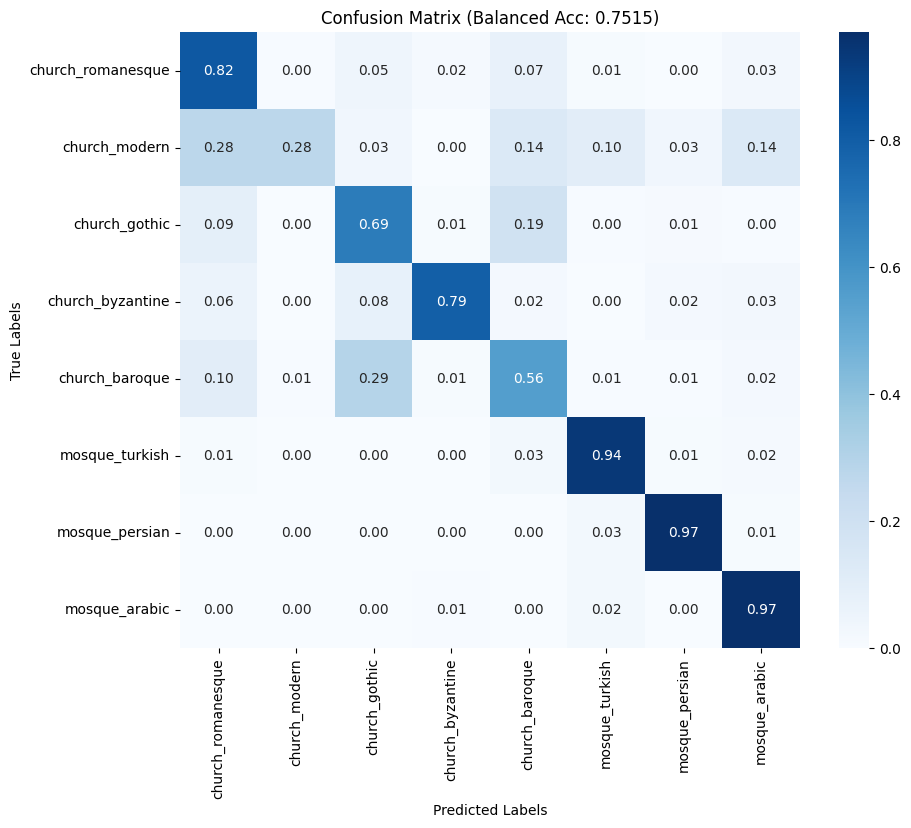

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the DataFrame
cm_df = pd.DataFrame(baseline_cm, index=all_classes, columns=all_classes)
print("Confusion Matrix:")
print(cm_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')  # Use '.2f' for float formatting
plt.title(f'Confusion Matrix (Balanced Acc: {baseline_balanced_acc:.4f})')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [26]:
# 11. Train balanced model
balanced_model = create_efficientnet_model()
optimizer = optim.SGD(balanced_model.parameters(),
                     lr=best_params['lr'],
                     momentum=0.9,
                     weight_decay=best_params['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=15)

print("Training balanced model (EfficientNet-B0, 160x160, Balanced)")
balanced_model, balanced_history = train_model(
    balanced_model,
    balanced_combined_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=15,
    patience=3
)

balanced_results = evaluate_model(balanced_model, test_loader, criterion)
_, _, balanced_balanced_acc, balanced_cm, balanced_preds, balanced_labels = balanced_results

plot_confusion_matrix(
    balanced_cm,
    all_classes,
    f'Balanced Training Confusion Matrix (Balanced Acc: {balanced_balanced_acc:.4f})',
    os.path.join(output_dir, 'confusion_matrix_balanced.png')
)

Training balanced model (EfficientNet-B0, 160x160, Balanced)
Starting training...

Epoch 1/15
  [Batch 0] Loss: 4.5540
  [Batch 10] Loss: 2.6111


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 1.7096
  [Batch 30] Loss: 2.0320
  [Batch 40] Loss: 1.6722


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 50] Loss: 1.5012
  [Batch 60] Loss: 1.0005
  Train Loss: 1.8521, Train Acc: 0.4856
  Val Loss: 1.1889, Val Acc: 0.5987
  Improvement detected, saving model...

Epoch 2/15


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 0] Loss: 0.8682


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94410943 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 10] Loss: 0.8133
  [Batch 20] Loss: 1.1561
  [Batch 30] Loss: 0.8905
  [Batch 40] Loss: 0.7751
  [Batch 50] Loss: 0.3914
  [Batch 60] Loss: 0.5166
  Train Loss: 0.8225, Train Acc: 0.7106
  Val Loss: 0.9158, Val Acc: 0.6868
  Improvement detected, saving model...

Epoch 3/15
  [Batch 0] Loss: 0.5849
  [Batch 10] Loss: 0.4559


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 20] Loss: 0.4295


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 30] Loss: 0.6275
  [Batch 40] Loss: 0.5428
  [Batch 50] Loss: 0.5624
  [Batch 60] Loss: 0.3153
  Train Loss: 0.5611, Train Acc: 0.8033
  Val Loss: 0.8232, Val Acc: 0.7204
  Improvement detected, saving model...

Epoch 4/15


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 0] Loss: 0.4848
  [Batch 10] Loss: 0.3384
  [Batch 20] Loss: 0.2615


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 30] Loss: 0.6558
  [Batch 40] Loss: 0.3485
  [Batch 50] Loss: 0.5009
  [Batch 60] Loss: 0.4359
  Train Loss: 0.4365, Train Acc: 0.8436
  Val Loss: 0.7236, Val Acc: 0.7456
  Improvement detected, saving model...

Epoch 5/15
  [Batch 0] Loss: 0.4051


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.2908
  [Batch 20] Loss: 0.3977
  [Batch 30] Loss: 0.2406


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 40] Loss: 0.4626


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 50] Loss: 0.3206
  [Batch 60] Loss: 0.2399
  Train Loss: 0.3574, Train Acc: 0.8724
  Val Loss: 0.6860, Val Acc: 0.7674
  Improvement detected, saving model...

Epoch 6/15
  [Batch 0] Loss: 0.2266


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.3352
  [Batch 20] Loss: 0.2408


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 30] Loss: 0.2270
  [Batch 40] Loss: 0.1729
  [Batch 50] Loss: 0.3671
  [Batch 60] Loss: 0.2440
  Train Loss: 0.2935, Train Acc: 0.8960
  Val Loss: 0.6936, Val Acc: 0.7750
  Improvement detected, saving model...

Epoch 7/15


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 0] Loss: 0.2381


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 10] Loss: 0.3674
  [Batch 20] Loss: 0.1650
  [Batch 30] Loss: 0.1597


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 40] Loss: 0.2908
  [Batch 50] Loss: 0.2021
  [Batch 60] Loss: 0.1495
  Train Loss: 0.2331, Train Acc: 0.9165
  Val Loss: 0.7126, Val Acc: 0.7649
  No improvement. (1/3)

Epoch 8/15


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 0] Loss: 0.2328


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.1658
  [Batch 20] Loss: 0.2855
  [Batch 30] Loss: 0.2270
  [Batch 40] Loss: 0.1550


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 50] Loss: 0.0991
  [Batch 60] Loss: 0.3744
  Train Loss: 0.1941, Train Acc: 0.9309
  Val Loss: 0.6863, Val Acc: 0.7842
  Improvement detected, saving model...

Epoch 9/15


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 0] Loss: 0.1763
  [Batch 10] Loss: 0.2618
  [Batch 20] Loss: 0.2001
  [Batch 30] Loss: 0.1444
  [Batch 40] Loss: 0.0941
  [Batch 50] Loss: 0.1318
  [Batch 60] Loss: 0.1053
  Train Loss: 0.1738, Train Acc: 0.9370
  Val Loss: 0.7081, Val Acc: 0.7741
  No improvement. (1/3)

Epoch 10/15
  [Batch 0] Loss: 0.2084
  [Batch 10] Loss: 0.3000
  [Batch 20] Loss: 0.2942


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 30] Loss: 0.1059


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 40] Loss: 0.0840
  [Batch 50] Loss: 0.2424


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (99050169 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 60] Loss: 0.1671
  Train Loss: 0.1535, Train Acc: 0.9478
  Val Loss: 0.6574, Val Acc: 0.7926
  Improvement detected, saving model...

Epoch 11/15


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 0] Loss: 0.0865
  [Batch 10] Loss: 0.0438


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 20] Loss: 0.1173
  [Batch 30] Loss: 0.1368
  [Batch 40] Loss: 0.1993
  [Batch 50] Loss: 0.1035
  [Batch 60] Loss: 0.1419
  Train Loss: 0.1322, Train Acc: 0.9545
  Val Loss: 0.6780, Val Acc: 0.7834
  No improvement. (1/3)

Epoch 12/15


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 0] Loss: 0.0931


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.1258
  [Batch 20] Loss: 0.1383
  [Batch 30] Loss: 0.1996
  [Batch 40] Loss: 0.0915
  [Batch 50] Loss: 0.1465


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 60] Loss: 0.1477
  Train Loss: 0.1263, Train Acc: 0.9586
  Val Loss: 0.6848, Val Acc: 0.7935
  Improvement detected, saving model...

Epoch 13/15


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 0] Loss: 0.1603
  [Batch 10] Loss: 0.2046
  [Batch 20] Loss: 0.0961


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 30] Loss: 0.1071
  [Batch 40] Loss: 0.1075
  [Batch 50] Loss: 0.0495


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 60] Loss: 0.0421
  Train Loss: 0.1068, Train Acc: 0.9653
  Val Loss: 0.6809, Val Acc: 0.7809
  No improvement. (1/3)

Epoch 14/15
  [Batch 0] Loss: 0.0641


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 10] Loss: 0.0817


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 20] Loss: 0.0902
  [Batch 30] Loss: 0.0392
  [Batch 40] Loss: 0.1625


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 50] Loss: 0.0701


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 60] Loss: 0.1406
  Train Loss: 0.1132, Train Acc: 0.9599
  Val Loss: 0.6783, Val Acc: 0.7867
  No improvement. (2/3)

Epoch 15/15


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 0] Loss: 0.1518
  [Batch 10] Loss: 0.0971


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 0.0971


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 30] Loss: 0.1572
  [Batch 40] Loss: 0.1109
  [Batch 50] Loss: 0.0734
  [Batch 60] Loss: 0.1872
  Train Loss: 0.1194, Train Acc: 0.9604
  Val Loss: 0.6767, Val Acc: 0.7825
  No improvement. (3/3)
Early stopping triggered.

Evaluating model on test set...
  Processed batch 0
  Processed batch 5
  Processed batch 10
  Processed batch 15

Test Results — Loss: 0.6767, Acc: 0.7825, Balanced Acc: 0.7937
Saving confusion matrix plot to: /content/drive/MyDrive/temple_classification_output/confusion_matrix_balanced.png
Plot saved.


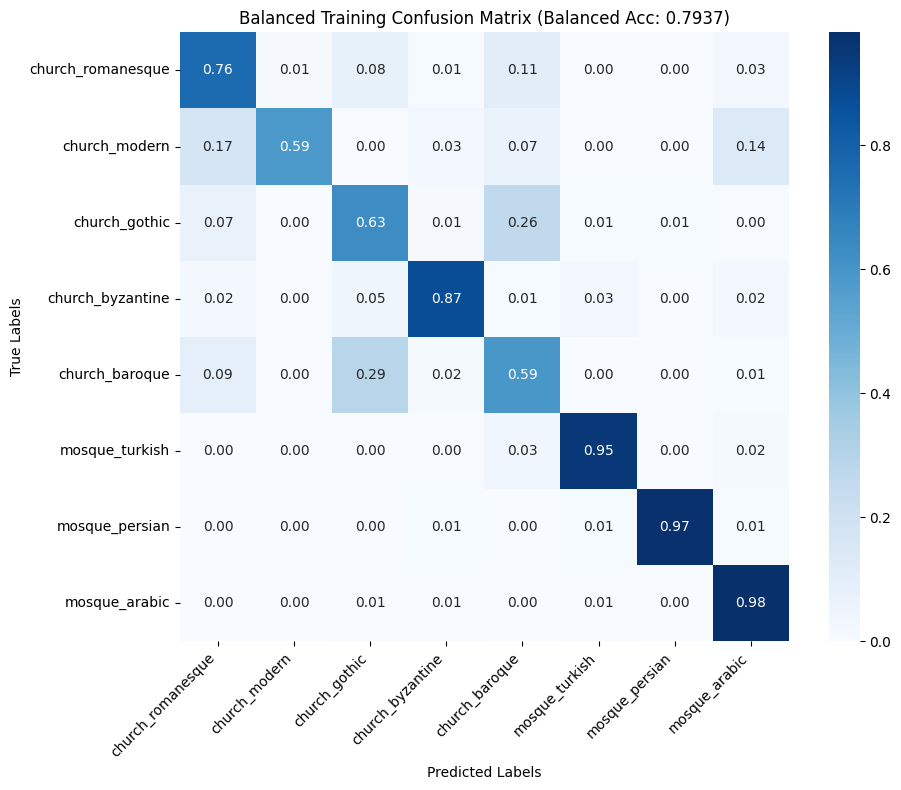

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
sns.heatmap(balanced_cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=all_classes, yticklabels=all_classes,
            cbar=True, square=True)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Balanced Training Confusion Matrix (Balanced Acc: {balanced_balanced_acc:.4f})')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'confusion_matrix_balanced_seaborn.png'))
plt.show()


In [29]:
print("# 12. Create high resolution datasets")

# Create high-res datasets using the existing directories
print("Loading high-resolution datasets...")
high_res_train_dataset = ImageFolder(root=train_dir, transform=train_transform_high_res)
high_res_val_dataset = ImageFolder(root=val_dir, transform=train_transform_high_res)
high_res_test_dataset = ImageFolder(root=test_dir, transform=val_transform_high_res)

print(f"  -> Train images: {len(high_res_train_dataset)}")
print(f"  -> Validation images: {len(high_res_val_dataset)}")
print(f"  -> Test images: {len(high_res_test_dataset)}")

# Combine train and val for final training
high_res_combined_dataset = torch.utils.data.ConcatDataset([high_res_train_dataset, high_res_val_dataset])
print(f"  -> Combined train + val images: {len(high_res_combined_dataset)}")

# Calculate class weights for balanced sampling
print("Calculating class weights for balanced sampling...")
high_res_class_counts = [0] * len(all_classes)
for dataset in [high_res_train_dataset, high_res_val_dataset]:
    for _, label in dataset.samples:
        high_res_class_counts[label] += 1

for idx, count in enumerate(high_res_class_counts):
    print(f"    - Class '{all_classes[idx]}': {count} samples")

high_res_class_weights = [1.0 / count for count in high_res_class_counts]

# Create sample weights
print("Creating sample weights...")
high_res_sample_weights = []
for dataset in [high_res_train_dataset, high_res_val_dataset]:
    high_res_sample_weights.extend([high_res_class_weights[label] for _, label in dataset.samples])

print("Initializing balanced sampler and dataloaders...")
high_res_sampler = WeightedRandomSampler(weights=high_res_sample_weights, num_samples=len(high_res_combined_dataset), replacement=True)

# OPTIMIZATION: Use moderate batch size for high resolution
high_res_batch_size = 32
balanced_high_res_loader = DataLoader(high_res_combined_dataset, batch_size=high_res_batch_size, sampler=high_res_sampler, num_workers=2, pin_memory=True)
high_res_test_loader = DataLoader(high_res_test_dataset, batch_size=high_res_batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("High-res datasets and dataloaders are ready ✅\n")


# 12. Create high resolution datasets
Loading high-resolution datasets...
  -> Train images: 3489
  -> Validation images: 955
  -> Test images: 1191
  -> Combined train + val images: 4444
Calculating class weights for balanced sampling...
    - Class 'church_romanesque': 871 samples
    - Class 'church_modern': 113 samples
    - Class 'church_gothic': 985 samples
    - Class 'church_byzantine': 407 samples
    - Class 'church_baroque': 776 samples
    - Class 'mosque_turkish': 373 samples
    - Class 'mosque_persian': 379 samples
    - Class 'mosque_arabic': 540 samples
Creating sample weights...
Initializing balanced sampler and dataloaders...
High-res datasets and dataloaders are ready ✅



In [30]:
# 13. Train Balanced + High Resolution model
balanced_high_res_model = create_efficientnet_model()
optimizer = optim.SGD(balanced_high_res_model.parameters(),
                     lr=best_params['lr'],
                     momentum=0.9,
                     weight_decay=best_params['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=15)

print("Training balanced high resolution model (EfficientNet-B0, 224x224, Balanced)")
balanced_high_res_model, balanced_high_res_history = train_model(
    balanced_high_res_model,
    balanced_high_res_loader,
    high_res_test_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=15,
    patience=3
)

balanced_high_res_results = evaluate_model(balanced_high_res_model, high_res_test_loader, criterion)
_, _, balanced_high_res_balanced_acc, balanced_high_res_cm, balanced_high_res_preds, balanced_high_res_labels = balanced_high_res_results

plot_confusion_matrix(
    balanced_high_res_cm,
    all_classes,
    f'Balanced High Resolution Confusion Matrix (Balanced Acc: {balanced_high_res_balanced_acc:.4f})',
    os.path.join(output_dir, 'confusion_matrix_balanced_high_res.png')
)


Training balanced high resolution model (EfficientNet-B0, 224x224, Balanced)
Starting training...

Epoch 1/15
  [Batch 0] Loss: 3.5691
  [Batch 10] Loss: 2.1182
  [Batch 20] Loss: 2.0766
  [Batch 30] Loss: 1.4107
  [Batch 40] Loss: 1.6606
  [Batch 50] Loss: 1.2366
  [Batch 60] Loss: 0.7815


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (102240660 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 70] Loss: 1.1328
  [Batch 80] Loss: 1.4131
  [Batch 90] Loss: 1.2675


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 100] Loss: 0.7714
  [Batch 110] Loss: 0.9327


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (95761000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 120] Loss: 0.5621
  [Batch 130] Loss: 0.8259
  Train Loss: 1.4765, Train Acc: 0.5531
  Val Loss: 0.9510, Val Acc: 0.6558
  Improvement detected, saving model...

Epoch 2/15
  [Batch 0] Loss: 0.8692
  [Batch 10] Loss: 0.8354


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 1.0574
  [Batch 30] Loss: 1.0492
  [Batch 40] Loss: 0.6637
  [Batch 50] Loss: 0.8691
  [Batch 60] Loss: 0.6824
  [Batch 70] Loss: 0.5567
  [Batch 80] Loss: 0.4647
  [Batch 90] Loss: 0.9824


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 100] Loss: 0.3619
  [Batch 110] Loss: 0.5132


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 120] Loss: 0.9373
  [Batch 130] Loss: 0.7854
  Train Loss: 0.7123, Train Acc: 0.7525
  Val Loss: 0.8968, Val Acc: 0.7028
  Improvement detected, saving model...

Epoch 3/15
  [Batch 0] Loss: 0.3515
  [Batch 10] Loss: 0.5031
  [Batch 20] Loss: 0.7041
  [Batch 30] Loss: 0.5235
  [Batch 40] Loss: 0.3710
  [Batch 50] Loss: 0.6473
  [Batch 60] Loss: 0.5498
  [Batch 70] Loss: 0.7174
  [Batch 80] Loss: 0.5140
  [Batch 90] Loss: 0.3576
  [Batch 100] Loss: 0.5409
  [Batch 110] Loss: 0.3720
  [Batch 120] Loss: 1.1482
  [Batch 130] Loss: 0.4969
  Train Loss: 0.5087, Train Acc: 0.8276
  Val Loss: 0.7247, Val Acc: 0.7481
  Improvement detected, saving model...

Epoch 4/15
  [Batch 0] Loss: 0.2564
  [Batch 10] Loss: 0.3135


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 20] Loss: 0.6676
  [Batch 30] Loss: 0.3630


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 40] Loss: 0.7690
  [Batch 50] Loss: 0.5916
  [Batch 60] Loss: 0.3479
  [Batch 70] Loss: 0.2956
  [Batch 80] Loss: 0.3606


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 90] Loss: 0.4376
  [Batch 100] Loss: 0.4942
  [Batch 110] Loss: 0.3005


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 120] Loss: 0.6162
  [Batch 130] Loss: 0.2408
  Train Loss: 0.3918, Train Acc: 0.8616
  Val Loss: 0.6930, Val Acc: 0.7599
  Improvement detected, saving model...

Epoch 5/15
  [Batch 0] Loss: 0.2534
  [Batch 10] Loss: 0.2838
  [Batch 20] Loss: 0.3136


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 30] Loss: 0.4439
  [Batch 40] Loss: 0.2199
  [Batch 50] Loss: 0.1245


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 60] Loss: 0.2117
  [Batch 70] Loss: 0.1499


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 80] Loss: 0.1351
  [Batch 90] Loss: 0.4468
  [Batch 100] Loss: 0.3117
  [Batch 110] Loss: 0.1954
  [Batch 120] Loss: 0.3243
  [Batch 130] Loss: 0.2742
  Train Loss: 0.2959, Train Acc: 0.8933
  Val Loss: 0.6577, Val Acc: 0.7758
  Improvement detected, saving model...

Epoch 6/15
  [Batch 0] Loss: 0.2950


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 10] Loss: 0.2525
  [Batch 20] Loss: 0.2320
  [Batch 30] Loss: 0.0838
  [Batch 40] Loss: 0.3020
  [Batch 50] Loss: 0.1541
  [Batch 60] Loss: 0.4760


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 70] Loss: 0.1463
  [Batch 80] Loss: 0.4003
  [Batch 90] Loss: 0.1295
  [Batch 100] Loss: 0.4118
  [Batch 110] Loss: 0.2016
  [Batch 120] Loss: 0.2960


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 130] Loss: 0.1434
  Train Loss: 0.2535, Train Acc: 0.9129
  Val Loss: 0.6720, Val Acc: 0.7918
  Improvement detected, saving model...

Epoch 7/15
  [Batch 0] Loss: 0.1903
  [Batch 10] Loss: 0.1905
  [Batch 20] Loss: 0.4268


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 30] Loss: 0.0742
  [Batch 40] Loss: 0.1780
  [Batch 50] Loss: 0.4717
  [Batch 60] Loss: 0.2834


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 70] Loss: 0.1415
  [Batch 80] Loss: 0.3414
  [Batch 90] Loss: 0.1171
  [Batch 100] Loss: 0.0616
  [Batch 110] Loss: 0.2649
  [Batch 120] Loss: 0.1609
  [Batch 130] Loss: 0.1168
  Train Loss: 0.1929, Train Acc: 0.9307
  Val Loss: 0.6655, Val Acc: 0.7985
  Improvement detected, saving model...

Epoch 8/15
  [Batch 0] Loss: 0.2850
  [Batch 10] Loss: 0.1118
  [Batch 20] Loss: 0.2298
  [Batch 30] Loss: 0.1059
  [Batch 40] Loss: 0.0962
  [Batch 50] Loss: 0.1946
  [Batch 60] Loss: 0.0655


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 70] Loss: 0.0741
  [Batch 80] Loss: 0.1599


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 90] Loss: 0.3193
  [Batch 100] Loss: 0.0983


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 110] Loss: 0.1647
  [Batch 120] Loss: 0.0608
  [Batch 130] Loss: 0.2366
  Train Loss: 0.1625, Train Acc: 0.9437
  Val Loss: 0.6456, Val Acc: 0.8035
  Improvement detected, saving model...

Epoch 9/15
  [Batch 0] Loss: 0.0951
  [Batch 10] Loss: 0.0645
  [Batch 20] Loss: 0.1671
  [Batch 30] Loss: 0.0679
  [Batch 40] Loss: 0.1025


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 50] Loss: 0.0658
  [Batch 60] Loss: 0.1566
  [Batch 70] Loss: 0.1326
  [Batch 80] Loss: 0.0988
  [Batch 90] Loss: 0.0339
  [Batch 100] Loss: 0.1702
  [Batch 110] Loss: 0.2553


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 120] Loss: 0.1083


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89943056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 130] Loss: 0.2180
  Train Loss: 0.1301, Train Acc: 0.9577
  Val Loss: 0.6668, Val Acc: 0.8069
  Improvement detected, saving model...

Epoch 10/15


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94169282 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 0] Loss: 0.2054
  [Batch 10] Loss: 0.1335


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 20] Loss: 0.1110
  [Batch 30] Loss: 0.0921
  [Batch 40] Loss: 0.1933


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 50] Loss: 0.2284
  [Batch 60] Loss: 0.1185
  [Batch 70] Loss: 0.0986
  [Batch 80] Loss: 0.2534
  [Batch 90] Loss: 0.0576
  [Batch 100] Loss: 0.0605
  [Batch 110] Loss: 0.0505
  [Batch 120] Loss: 0.0906
  [Batch 130] Loss: 0.1188
  Train Loss: 0.1055, Train Acc: 0.9651
  Val Loss: 0.6879, Val Acc: 0.8178
  Improvement detected, saving model...

Epoch 11/15
  [Batch 0] Loss: 0.2431
  [Batch 10] Loss: 0.1742
  [Batch 20] Loss: 0.0424
  [Batch 30] Loss: 0.0192


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 40] Loss: 0.1194
  [Batch 50] Loss: 0.1674
  [Batch 60] Loss: 0.0847
  [Batch 70] Loss: 0.0666


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 80] Loss: 0.3405
  [Batch 90] Loss: 0.0917
  [Batch 100] Loss: 0.0800
  [Batch 110] Loss: 0.1957
  [Batch 120] Loss: 0.0842
  [Batch 130] Loss: 0.0758
  Train Loss: 0.1110, Train Acc: 0.9644
  Val Loss: 0.6830, Val Acc: 0.8220
  Improvement detected, saving model...

Epoch 12/15
  [Batch 0] Loss: 0.0513


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 10] Loss: 0.0133
  [Batch 20] Loss: 0.0585


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 30] Loss: 0.0376
  [Batch 40] Loss: 0.1615
  [Batch 50] Loss: 0.3270
  [Batch 60] Loss: 0.0276
  [Batch 70] Loss: 0.0189
  [Batch 80] Loss: 0.1899
  [Batch 90] Loss: 0.0945
  [Batch 100] Loss: 0.0447
  [Batch 110] Loss: 0.0121
  [Batch 120] Loss: 0.1538
  [Batch 130] Loss: 0.0963
  Train Loss: 0.0888, Train Acc: 0.9701
  Val Loss: 0.6673, Val Acc: 0.8254
  Improvement detected, saving model...

Epoch 13/15
  [Batch 0] Loss: 0.0835


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96826695 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


  [Batch 10] Loss: 0.0760


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 20] Loss: 0.0998


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 30] Loss: 0.2088
  [Batch 40] Loss: 0.0165
  [Batch 50] Loss: 0.1122
  [Batch 60] Loss: 0.0272
  [Batch 70] Loss: 0.1879
  [Batch 80] Loss: 0.0399
  [Batch 90] Loss: 0.0966
  [Batch 100] Loss: 0.0935
  [Batch 110] Loss: 0.1224
  [Batch 120] Loss: 0.0800
  [Batch 130] Loss: 0.1734
  Train Loss: 0.0752, Train Acc: 0.9761
  Val Loss: 0.6785, Val Acc: 0.8161
  No improvement. (1/3)

Epoch 14/15
  [Batch 0] Loss: 0.0736
  [Batch 10] Loss: 0.0147
  [Batch 20] Loss: 0.1395
  [Batch 30] Loss: 0.0445
  [Batch 40] Loss: 0.0269


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 50] Loss: 0.1275
  [Batch 60] Loss: 0.0421
  [Batch 70] Loss: 0.0949
  [Batch 80] Loss: 0.1818
  [Batch 90] Loss: 0.0633
  [Batch 100] Loss: 0.0350
  [Batch 110] Loss: 0.0785
  [Batch 120] Loss: 0.0828
  [Batch 130] Loss: 0.1321
  Train Loss: 0.0786, Train Acc: 0.9752
  Val Loss: 0.6770, Val Acc: 0.8212
  No improvement. (2/3)

Epoch 15/15
  [Batch 0] Loss: 0.0839
  [Batch 10] Loss: 0.0120
  [Batch 20] Loss: 0.0402
  [Batch 30] Loss: 0.0128
  [Batch 40] Loss: 0.2057
  [Batch 50] Loss: 0.0241
  [Batch 60] Loss: 0.1040


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  [Batch 70] Loss: 0.0939
  [Batch 80] Loss: 0.1027
  [Batch 90] Loss: 0.0463
  [Batch 100] Loss: 0.0145
  [Batch 110] Loss: 0.1764
  [Batch 120] Loss: 0.0722
  [Batch 130] Loss: 0.0116


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


  Train Loss: 0.0740, Train Acc: 0.9775
  Val Loss: 0.6673, Val Acc: 0.8186
  No improvement. (3/3)
Early stopping triggered.

Evaluating model on test set...
  Processed batch 0
  Processed batch 5
  Processed batch 10
  Processed batch 15
  Processed batch 20
  Processed batch 25
  Processed batch 30
  Processed batch 35

Test Results — Loss: 0.6673, Acc: 0.8186, Balanced Acc: 0.8067
Saving confusion matrix plot to: /content/drive/MyDrive/temple_classification_output/confusion_matrix_balanced_high_res.png
Plot saved.


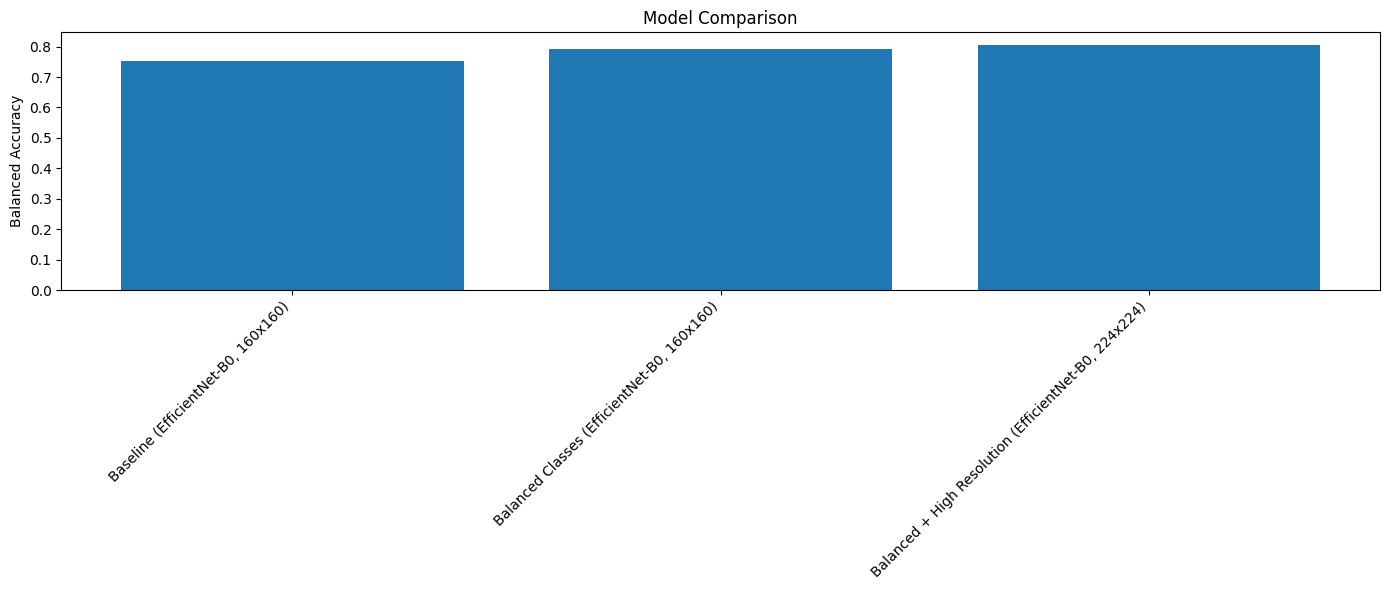

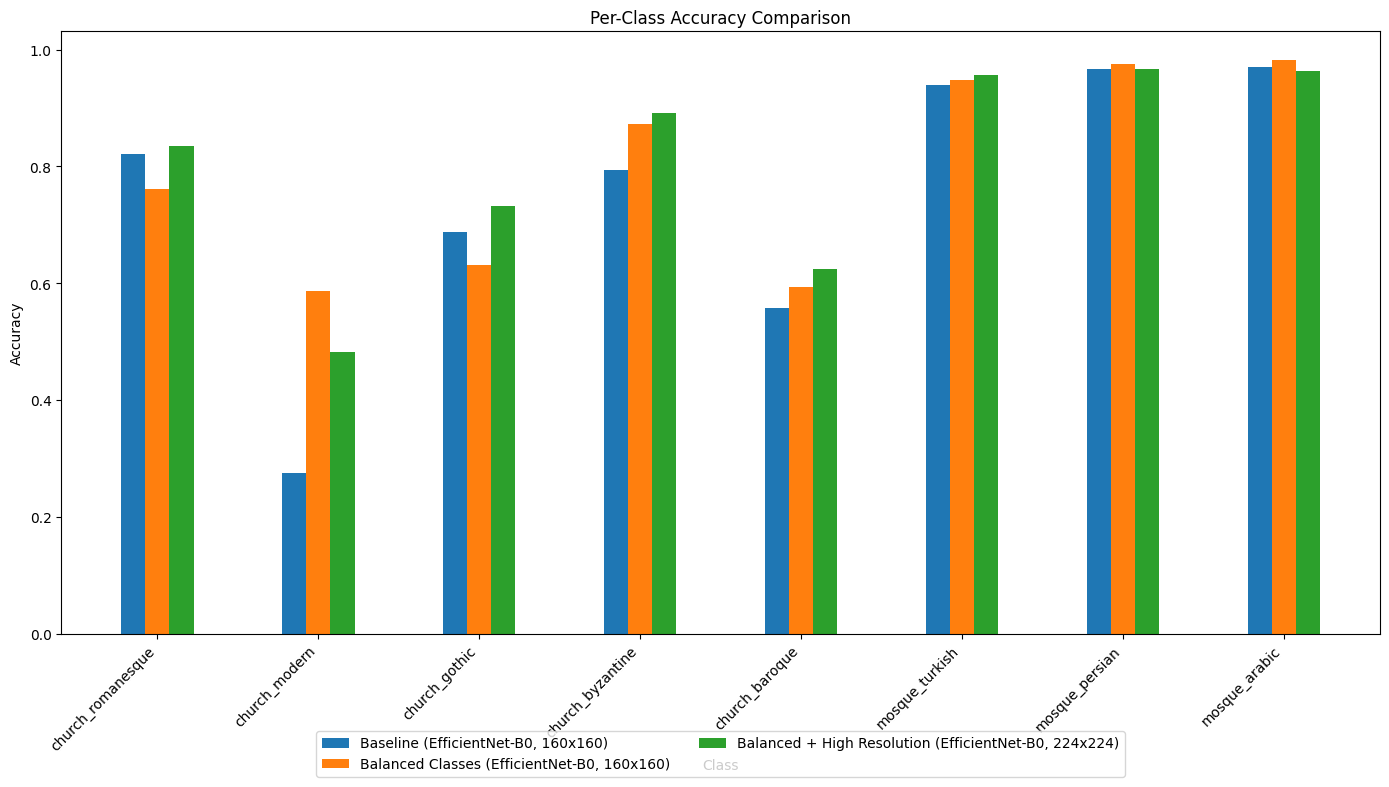

In [33]:
models_results = {
    "Baseline (EfficientNet-B0, 160x160)": {
        "balanced_acc": baseline_balanced_acc,
        "confusion_matrix": baseline_cm,
    },
    "Balanced Classes (EfficientNet-B0, 160x160)": {
        "balanced_acc": balanced_balanced_acc,
        "confusion_matrix": balanced_cm,
    },
    "Balanced + High Resolution (EfficientNet-B0, 224x224)": {
        "balanced_acc": balanced_high_res_balanced_acc,
        "confusion_matrix": balanced_high_res_cm,
    }
}

# Create comparison bar chart
plt.figure(figsize=(14, 6))
models_list = list(models_results.keys())
accuracies = [models_results[model]["balanced_acc"] for model in models_list]

plt.bar(models_list, accuracies)
plt.ylabel('Balanced Accuracy')
plt.title('Model Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'model_comparison.png'))
plt.show()  # Show the plot
# plt.close()  # Optional: close if you want to clear memory

# Create per-class accuracy comparison
per_class_results = {}
for model_name, model_data in models_results.items():
    per_class_results[model_name] = model_data["confusion_matrix"].diagonal()

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(all_classes))
width = 0.15
multiplier = 0

print()

for model_name, accuracies in per_class_results.items():
    offset = width * multiplier
    ax.bar(x + offset, accuracies, width, label=model_name)
    multiplier += 1

ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy Comparison')
ax.set_xticks(x + width * 1)
ax.set_xticklabels(all_classes, rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'per_class_comparison.png'))
plt.show()  # Show the plot
# plt.close()  # Optional


In [34]:
class TempleArchitectureClassifier:
    def __init__(self, model_path=os.path.join(output_dir, 'best_model.pth'), resolution=160):
        self.classes = all_classes
        self.church_styles = church_styles
        self.mosque_styles = mosque_styles
        self.resolution = resolution

        # Setup transform
        if resolution == 160:
            self.transform = transforms.Compose([
                transforms.Resize(192),
                transforms.CenterCrop(160),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:  # 224
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        # Load model
        self.model = create_efficientnet_model(len(self.classes))
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.to(device)
        self.model.eval()

    def predict(self, image_path):
        # Load and preprocess image
        img = Image.open(image_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            outputs = self.model(img_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        # Get class name and confidence
        predicted_class = self.classes[predicted.item()]
        confidence_score = confidence.item()

        # Determine if it's a church or mosque
        if predicted_class in self.church_styles:
            building_type = "Church"
        else:
            building_type = "Mosque"

        # Get top-3 predictions
        top_probs, top_indices = torch.topk(probabilities, 3, dim=1)
        top_classes = [self.classes[idx] for idx in top_indices[0].cpu().numpy()]
        top_probs = top_probs[0].cpu().numpy()

        return {
            "predicted_class": predicted_class,
            "confidence": confidence_score,
            "building_type": building_type,
            "top3_classes": top_classes,
            "top3_probabilities": top_probs
        }

In [37]:
from google.colab import files
uploaded = files.upload()


Saving Q18158272_wd0.jpg to Q18158272_wd0.jpg


In [38]:
image_path = 'Q18158272_wd0.jpg'
result = classifier.predict(image_path)
from pprint import pprint
pprint(result)
# mazbout

{'building_type': 'Church',
 'confidence': 0.9999582767486572,
 'predicted_class': 'church_gothic',
 'top3_classes': ['church_gothic', 'church_baroque', 'church_byzantine'],
 'top3_probabilities': array([9.9995828e-01, 3.1846488e-05, 5.6967715e-06], dtype=float32)}


In [40]:
# evaluating to see the f1score ...
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, criterion, device=device):
    print("\nEvaluating model on test set...")
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if i % 5 == 0:
                print(f"  Processed batch {i}")

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Per-class metrics
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    print(f"\nTest Results — Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, Balanced Acc: {balanced_acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'balanced_acc': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm_normalized,
        'predictions': all_preds,
        'labels': all_labels
    }

# For baseline model
baseline_results = evaluate_model(baseline_model, test_loader, criterion)
baseline_balanced_acc = baseline_results['balanced_acc']
baseline_cm = baseline_results['confusion_matrix']
baseline_preds = baseline_results['predictions']
baseline_labels = baseline_results['labels']

# For balanced model
balanced_results = evaluate_model(balanced_model, test_loader, criterion)
balanced_balanced_acc = balanced_results['balanced_acc']
balanced_cm = balanced_results['confusion_matrix']
balanced_preds = balanced_results['predictions']
balanced_labels = balanced_results['labels']

# For high-res model
balanced_high_res_results = evaluate_model(balanced_high_res_model, high_res_test_loader, criterion)
balanced_high_res_balanced_acc = balanced_high_res_results['balanced_acc']
balanced_high_res_cm = balanced_high_res_results['confusion_matrix']
balanced_high_res_preds = balanced_high_res_results['predictions']
balanced_high_res_labels = balanced_high_res_results['labels']


Evaluating model on test set...
  Processed batch 0
  Processed batch 5
  Processed batch 10
  Processed batch 15

Test Results — Loss: 0.7889, Acc: 0.7817, Balanced Acc: 0.7515
Precision: 0.7789, Recall: 0.7817, F1: 0.7761

Evaluating model on test set...
  Processed batch 0
  Processed batch 5
  Processed batch 10
  Processed batch 15

Test Results — Loss: 0.6767, Acc: 0.7825, Balanced Acc: 0.7937
Precision: 0.7837, Recall: 0.7825, F1: 0.7820

Evaluating model on test set...
  Processed batch 0
  Processed batch 5
  Processed batch 10
  Processed batch 15
  Processed batch 20
  Processed batch 25
  Processed batch 30
  Processed batch 35

Test Results — Loss: 0.6673, Acc: 0.8186, Balanced Acc: 0.8067
Precision: 0.8174, Recall: 0.8186, F1: 0.8167


In [41]:
models_results = {
    "Baseline (EfficientNet-B0, 160x160)": {
        "balanced_acc": baseline_results['balanced_acc'],
        "precision": baseline_results['precision'],
        "recall": baseline_results['recall'],
        "f1": baseline_results['f1'],
        "confusion_matrix": baseline_results['confusion_matrix'],
    },
    "Balanced Classes (EfficientNet-B0, 160x160)": {
        "balanced_acc": balanced_results['balanced_acc'],
        "precision": balanced_results['precision'],
        "recall": balanced_results['recall'],
        "f1": balanced_results['f1'],
        "confusion_matrix": balanced_results['confusion_matrix'],
    },
    "Balanced + High Resolution (EfficientNet-B0, 224x224)": {
        "balanced_acc": balanced_high_res_results['balanced_acc'],
        "precision": balanced_high_res_results['precision'],
        "recall": balanced_high_res_results['recall'],
        "f1": balanced_high_res_results['f1'],
        "confusion_matrix": balanced_high_res_results['confusion_matrix'],
    }
}

<ipython-input-50-233fbdd58a2d>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = df.applymap(lambda x: f"{x:.4f}")


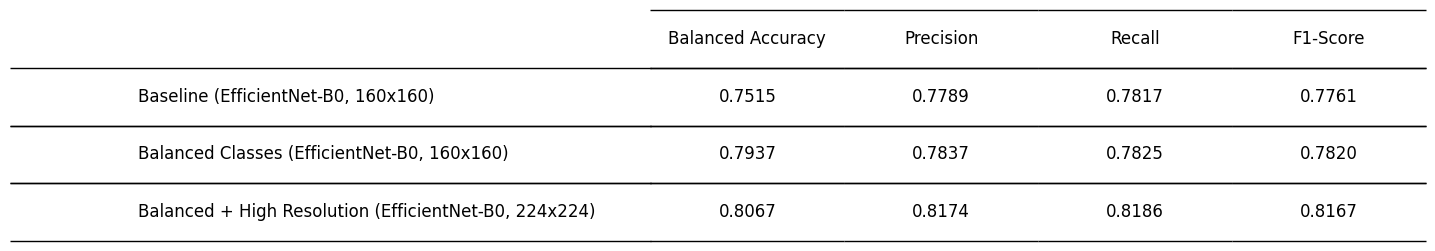

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(models_results).T
df = df[['balanced_acc', 'precision', 'recall', 'f1']]
df.columns = ['Balanced Accuracy', 'Precision', 'Recall', 'F1-Score']

# Format numbers to exactly 4 decimal places (as strings)
formatted_df = df.applymap(lambda x: f"{x:.4f}")

plt.figure(figsize=(10, 3))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Create the table with additional parameters for spacing
table = pd.plotting.table(
    ax,
    formatted_df,  # Use formatted strings instead of rounded numbers
    loc='center',
    cellLoc='center',
    colWidths=[0.2] * len(df.columns),
    # Add these parameters for spacing:
    cellColours=None,  # Can specify colors if needed
    edges='horizontal',  # Show only horizontal lines
    bbox=[0, 0, 1, 1]  # This helps with positioning
)

# Adjust table properties for better spacing
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # Increased vertical scaling for row spacing

# Adjust cell padding
for key, cell in table.get_celld().items():
    cell.set_height(0.2)  # Adjust cell height
    cell.PAD = 0.2  # Add padding around cell content

plt.savefig('metrics_table.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [51]:
from google.colab import files
uploaded = files.upload()



Saving Q28917209_wd0.jpg to Q28917209_wd0.jpg


In [52]:
image_path = 'Q28917209_wd0.jpg'
result = classifier.predict(image_path)
from pprint import pprint
pprint(result)
# ghalat

{'building_type': 'Church',
 'confidence': 0.4655817449092865,
 'predicted_class': 'church_baroque',
 'top3_classes': ['church_baroque', 'church_modern', 'church_gothic'],
 'top3_probabilities': array([0.46558174, 0.25227585, 0.19068852], dtype=float32)}


In [53]:
from google.colab import files
uploaded = files.upload()



Saving Q5949_wd0.jpg to Q5949_wd0.jpg


In [54]:
image_path = 'Q5949_wd0.jpg'
result = classifier.predict(image_path)
from pprint import pprint
pprint(result)
# mazbout

{'building_type': 'Church',
 'confidence': 0.9992850422859192,
 'predicted_class': 'church_gothic',
 'top3_classes': ['church_gothic', 'church_baroque', 'church_romanesque'],
 'top3_probabilities': array([9.9928504e-01, 7.0484774e-04, 6.3841831e-06], dtype=float32)}
